In [2]:
import numba
import numpy as np
from numba import cuda, float32, int32
from timeit import default_timer as timer

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")


@cuda.jit
def kernel_get_triplet_2d_assemble_data(arr_in_1, arr_out_1, prefix_sum):
  thId = cuda.grid(1)
  
  if thId + 1 >= prefix_sum.shape[0]:
    return

  start = prefix_sum[thId]
  end = prefix_sum[thId + 1]
  for i in range(start, end):
    arr_out_1[i] = arr_in_1[i - start][thId]



In [10]:
N = 158339
host_arr_in = np.zeros(shape=(40, N), dtype=np.int32)
host_arr_len = np.zeros(shape=(N + 1), dtype=int)
for i in range(N):
  l = 30 + (i) % (9)
  host_arr_in[:l, i] = i + 1
  host_arr_len[i + 1] = l
host_prefix_sum = np.cumsum(host_arr_len.astype(int))
print(host_arr_in.astype(int))
print(host_arr_len)
print(host_prefix_sum)

[[     1      2      3 ... 158337 158338 158339]
 [     1      2      3 ... 158337 158338 158339]
 [     1      2      3 ... 158337 158338 158339]
 ...
 [     0      0      0 ... 158337      0      0]
 [     0      0      0 ...      0      0      0]
 [     0      0      0 ...      0      0      0]]
[ 0 30 31 ... 38 30 31]
[      0      30      61 ... 5383458 5383488 5383519]


In [16]:
d_arr_in_1 = cuda.to_device(host_arr_in)
d_prefix_sum = cuda.to_device(host_prefix_sum)

d_arr_out_1 = cuda.device_array(shape=(int(host_prefix_sum[-1])), dtype=np.float64)

In [19]:
nb_threads = 1024
nb_blocks = d_prefix_sum.shape[0] // nb_threads + 1
print(nb_blocks)
kernel_get_triplet_2d_assemble_data[nb_blocks, nb_threads](d_arr_in_1, d_arr_out_1, d_prefix_sum)
host_arr_out = d_arr_out_1.copy_to_host()
host_arr_out.astype(int)

155


array([     1,      1,      1, ..., 158339, 158339, 158339])

In [17]:
print(d_arr_in_1.dtype)
print(d_arr_out_1.dtype)

int32
float64


In [18]:
def test():
  kernel_get_triplet_2d_assemble_data[nb_blocks, nb_threads](
    d_arr_in_1,
    d_arr_out_1,
    d_prefix_sum
  )
  cuda.synchronize()

test()
test_time(70, test)

3.71633 ms


In [29]:

def host_kernel_get_triplet_2d_assemble_data(arr_in, arr_out, prefix_sum, N):
  for thId in range(N):
    start = prefix_sum[thId]
    end = prefix_sum[thId + 1]
    for i in range(start, end):
      arr_out[i] = arr_in[i - start][thId]

host_arr_out = np.zeros(shape=(int(host_prefix_sum[-1])), dtype=np.float32)
host_kernel_get_triplet_2d_assemble_data(host_arr_in, host_arr_out, host_prefix_sum, N)
host_arr_out.astype(int)

array([     1,      2,      2, ..., 158339, 158339, 158339])

# Test 2

In [21]:
import numba
import numpy as np
from numba import cuda, float32, int32
from timeit import default_timer as timer

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")


@cuda.jit
def kernel_get_triplet_2d_assemble_data(arr_in_1, arr_out_1, prefix_sum):
  thId = cuda.grid(1)

  if thId + 1 >= prefix_sum.shape[0]:
    return
  
  start = prefix_sum[thId]
  #end = 
  for i in range(start, prefix_sum[thId + 1]):
    p = i - start
    arr_out_1[i] = arr_in_1[thId][p]



In [38]:
np.random.rand()

0.8915130436195355

In [41]:
N = 158339
host_arr_in = np.zeros(shape=(40, N), dtype=np.float64)
host_arr_len = np.zeros(shape=(N + 1), dtype=int)
for i in range(N):
  l = 30 + (i % 9)
  host_arr_in[:l, i] = np.random.rand()
  host_arr_len[i + 1] = l
host_prefix_sum = np.cumsum(host_arr_len.astype(int))
host_arr_in = host_arr_in.T
print(host_arr_in)
print(host_arr_len)
print(host_prefix_sum)

[[0.38386584 0.38386584 0.38386584 ... 0.         0.         0.        ]
 [0.76185161 0.76185161 0.76185161 ... 0.         0.         0.        ]
 [0.5672524  0.5672524  0.5672524  ... 0.         0.         0.        ]
 ...
 [0.9569907  0.9569907  0.9569907  ... 0.9569907  0.         0.        ]
 [0.00669746 0.00669746 0.00669746 ... 0.         0.         0.        ]
 [0.28924507 0.28924507 0.28924507 ... 0.         0.         0.        ]]
[ 0 30 31 ... 38 30 31]
[      0      30      61 ... 5383458 5383488 5383519]


In [42]:
d_arr_in_1 = cuda.to_device(host_arr_in)
d_prefix_sum = cuda.to_device(host_prefix_sum)

d_arr_out_1 = cuda.device_array(shape=(int(host_prefix_sum[-1])), dtype=np.float64)

In [43]:
nb_threads = 1024
nb_blocks = N // nb_threads + 1
kernel_get_triplet_2d_assemble_data[nb_blocks, nb_threads](d_arr_in_1, d_arr_out_1, d_prefix_sum)
host_arr_out = d_arr_out_1.copy_to_host()
host_arr_out.astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
print(d_arr_in_1.shape)
print(d_arr_in_1.dtype)
print(d_arr_out_1.shape)
print(d_arr_out_1.dtype)

(158339, 40)
float64
(5383519,)
float64


In [45]:
def test():
  kernel_get_triplet_2d_assemble_data[nb_blocks, nb_threads](d_arr_in_1, d_arr_out_1, d_prefix_sum)
  cuda.synchronize()

test()
test_time(700, test)

4.88637 ms


# Test 3

In [2]:
import numba
import numpy as np
from numba import cuda, float32, int32
from timeit import default_timer as timer

def test_time(iter, fun):
  #fun()
  start_time = timer()
  for _ in range(iter):
    fun()
  end_time = timer()
  elapsed_time = (end_time - start_time) / iter
  print(f"{elapsed_time * 1000:.5f} ms")
  #print(f"{elapsed_time * 1000000:.5f} micros")

In [84]:
OUT_N = 4496676
SIZE = 40
N = 158339


host_a_loc = np.zeros(shape=(OUT_N), dtype=np.float64)
host_jcn_loc = np.zeros(shape=(OUT_N), dtype=np.int32)
host_irn_loc = np.zeros(shape=(OUT_N), dtype=np.int32)

host_a_loc_2 = np.zeros(shape=(SIZE, N), dtype=np.float64)
host_jcn_loc_2 = np.zeros(shape=(SIZE, N), dtype=np.int32)
host_irn_loc_2 = np.zeros(shape=(SIZE, N), dtype=np.int32)

host_arr_len = np.zeros(shape=(158720), dtype=np.int32)
temp = OUT_N
for i in range(N):
  l = 29
  if temp == 0:
    break
  if temp >= l:
    temp -= l
  else:
    l = temp
    temp = 0
  host_a_loc_2[:l, i] = 0.0
  host_jcn_loc_2[:l, i] = 0.0
  host_irn_loc_2[:l, i] = 0.0
  host_arr_len[i + 1] = l

host_a_loc_2 = host_a_loc_2.T
host_jcn_loc_2 = host_jcn_loc_2.T
host_irn_loc_2 = host_irn_loc_2.T

host_prefix_sum = np.cumsum(host_arr_len.astype(np.int32))
host_prefix_sum = host_prefix_sum.astype(np.int32)
print(host_a_loc_2)
print(host_arr_len)
print(host_prefix_sum)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[ 0 29 29 ...  0  0  0]
[      0      29      58 ... 4496676 4496676 4496676]


In [85]:
d_a_loc = cuda.to_device(host_a_loc)
d_jcn_loc = cuda.to_device(host_jcn_loc)
d_irn_loc = cuda.to_device(host_irn_loc)
d_a_loc_2 = cuda.to_device(host_a_loc_2)
d_jcn_loc_2 = cuda.to_device(host_jcn_loc_2)
d_irn_loc_2 = cuda.to_device(host_irn_loc_2)
d_prefix_sum = cuda.to_device(host_prefix_sum)

In [86]:
print(d_a_loc.dtype)
print(d_a_loc_2.dtype)
print(d_jcn_loc.dtype)
print(d_jcn_loc_2.dtype)
print(d_irn_loc.dtype)
print(d_irn_loc_2.dtype)
print(d_prefix_sum.dtype)

float64
float64
int32
int32
int32
int32
int32


In [87]:
print(d_a_loc.shape)
print(d_a_loc_2.shape)
print(d_jcn_loc.shape)
print(d_jcn_loc_2.shape)
print(d_irn_loc.shape)
print(d_irn_loc_2.shape)
print(d_prefix_sum.shape)

(4496676,)
(158339, 40)
(4496676,)
(158339, 40)
(4496676,)
(158339, 40)
(158720,)


In [78]:
print(host_prefix_sum)

[      0      29      58 ... 4496676 4496676 4496676]


In [88]:
@cuda.jit
def kernel_get_triplet_2d_assemble_data(
    a_loc,
    jcn_loc,
    irn_loc,
    a_loc_2,
    jcn_loc_2,
    irn_loc_2,
    prefix_sum,
):

  idx = cuda.grid(1)

  if idx + 1 >= prefix_sum.shape[0]:
    return

  s = prefix_sum[idx]
  e = prefix_sum[idx + 1]
  for i in range(s, e):
    p = i - s
    jcn_loc[i] = jcn_loc_2[idx][p]
  for i in range(s, e):
    p = i - s
    irn_loc[i] = irn_loc_2[idx][p]
  for i in range(s, e):
    p = i - s
    a_loc[i] = a_loc_2[idx][p]

nb_element = d_prefix_sum.shape[0]
nb_threads = 1024
nb_blocks = nb_element // 1024 + 1
print(nb_blocks)

def cuda_numba_get_triplet_2d_assemble_data():
  kernel_get_triplet_2d_assemble_data[nb_blocks, nb_threads](
    d_a_loc,
    d_jcn_loc,
    d_irn_loc,
    d_a_loc_2,
    d_jcn_loc_2,
    d_irn_loc_2,
    d_prefix_sum,
  )
  cuda.synchronize()

cuda_numba_get_triplet_2d_assemble_data()
test_time(100, cuda_numba_get_triplet_2d_assemble_data)

156
7.19451 ms


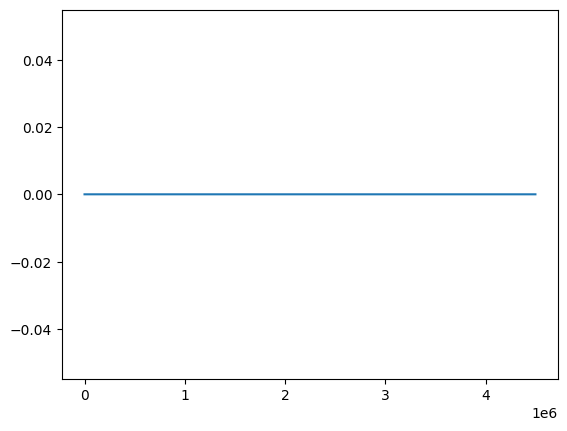

In [80]:
import matplotlib.pyplot as plt

plt.plot(host_a_loc)